# Hybrid forecasting methods and global models

## 1. Introduction

The **M** competition is a famous series of forecasting competitions.  In the competition forecasters are given multiple time series (e.g. in M4 they were given 100k time series). The winner is the team that produces forecasts that are closest to an unseen test set (measured using a range of point and prediction interval calculations).

For the first three M competitions it was typically a simple model that won. Machine learning models often did poorly relative to their statistical counterparts.  This changed with **M4** where a **hybrid** ML and classical time series model won the comptetition by some margin.  The approach combined a Recurrent Neural Network (RNN; a sequence predicting network) trained on all time series with Exponential Smoothing (ES) where the ES parameters were local to each time series.

The RNN in this example is called a **Global Model**.  The RNN has a single set of weights that it uses to predict all time series.

* A brief history of forecasting competitions (and their controversy!): https://www.sciencedirect.com/science/article/pii/S016920701930086X
* M4 forecasting results: https://www.sciencedirect.com/science/article/pii/S0169207019301128
* The winning entry described in detail: https://www.sciencedirect.com/science/article/pii/S0169207019301153

When the results of M4 were published, there were no implementations of Hybrid models available (the winning entry was coded from scratch).  But a few years later we now have some early forecasting packages appearing that exploit these ideas.  Here we will take a look at `NeuralProphet` a package that combines the feedforward neural network architecture with `Prophet`.

## 2. A new hybrid method: `NeuralProphet`

This is a relatively new package and as such you need to be aware that its documentation is not fully complete (or consistent) and that the interface, internal implementation, and dependencies may change over time (potentially between minor version updates).

The `Prophet` implementation is hard to extend (modify and add new features) as it is implemented in a specialist bayesian package https://mc-stan.org/.  `NeuralProphet` offers a more flexible implementation of such a model that combines a feedforward neural network (for autoregression as we explored in class and global modelling for multiple time series) and Prophet's trend, seasonality, and holidays.

### Uncertainty quantification: quantile forecasts

We always want to produce a model with prediction intervals.  We can do this in `NeuralProphet` using quantile regression.  Instead of predicting the mean value as in OLS regression, quantile regression predicts a chosen quantile. 

> For example, assume we are interprested in the 25% quantile of emergency department arrivals on a given day.  We would interpret this values as there is a 25% chance the number of arrivals is above this value and 25% below it.

Here we will produce an 95% prediction interval using the 2.5 and 97.5 quantiles.



## 3. Applying `NeuralProphet` to the Ambulance Time Series

We will apply `NeuralProphet` to the ambulance dataset reported here: https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-023-02218-z

The time series represents daily counts of the number of 999 calls that results in the dispatch of one or more ambulances.  The dataset is made up of multiple regional time series that contain multiple seasonality, and holiday effects.


### imports

In [1]:
from neuralprophet import NeuralProphet, set_log_level
import pandas as pd
import numpy as np

# Disable logging messages unless there is an error
set_log_level("ERROR")

### Read in online ambulance data and pre-process

The ambulance data is stored online and can be downloaded from the following URL


In [2]:
url = 'https://raw.githubusercontent.com/TomMonks/swast-benchmarking' \
        + '/main/data/Daily_Responses_5_Years_2019_full.csv'

### Function to preprocess the dataset to model a single time series

The dataset is stored in a **tidy** format.  Later we will see that this is a useful format for global modelling.  But for now we we will convert the dataset to wide format to easily allow us to select individual time series.

In [3]:
def pre_process_daily_data(path, index_col, by_col, 
                           values, dayfirst=False):
    '''
    Daily data is stored in long format.  Read in 
    and pivot to wide format so that there is a single 
    column for each regions time series.
    '''
    df = pd.read_csv(path, index_col=index_col, parse_dates=True, 
                     dayfirst=dayfirst)
    df.columns = map(str.lower, df.columns)
    df.index.rename(str(df.index.name).lower(), inplace=True)
    
    clean_table = pd.pivot_table(df, values=values.lower(), 
                                 index=[index_col.lower()],
                                 columns=[by_col.lower()], aggfunc=np.sum)
    
    clean_table.index.freq = 'D'
    
    return clean_table

### Function to convert to prophet format data

This function converts a standard time series into a input suitable for a prophet model.  The dataset is compatible with both prophet and `NeuralProphet`

In [4]:
def prophet_training_data(y_train):
    '''
    Converts a standard pandas datetimeindexed dataframe
    for time series into one suitable for Prophet
    Parameters:
    ---------
    y_train: pd.DataFrame
        univariate time series data
        
    Returns:
    --------
        pd.DataFrame in Prophet format 
        columns = ['ds', 'y']
    '''
    prophet_train = pd.DataFrame(y_train.index)
    prophet_train['y'] = y_train.to_numpy()
    prophet_train.columns = ['ds', 'y']

    return prophet_train

### Function to create holiday dataframe

The ambulance time series only has a single holiday to model - new years data.  This function produces a dataframe that can be given to the `NeuralProphet` model.

In [5]:
def new_years_day_events():

    df_events = pd.DataFrame(
        {
            "event": "new years day",
            "ds": pd.to_datetime(
                [
                    "2014-01-01",
                    "2015-01-01",
                    "2016-01-01",
                    "2017-01-01",
                    "2018-01-01",
                    "2019-01-01",
                    "2020-01-01",
                    "2021-01-01"
                ]
            ),
        }
    )

    return df_events

### Read in clean data and peek

In [6]:
clean = pre_process_daily_data(url, 'Actual_dt', 'ORA', 'Actual_Value', 
                               dayfirst=False)
clean.head()

ora         BNSSG  Cornwall  Devon  Dorset  Gloucestershire  OOA  Somerset  \
actual_dt                                                                    
2013-12-30  415.0     220.0  502.0   336.0            129.0  NaN     183.0   
2013-12-31  420.0     236.0  468.0   302.0            128.0  NaN     180.0   
2014-01-01  549.0     341.0  566.0   392.0            157.0  NaN     213.0   
2014-01-02  450.0     218.0  499.0   301.0            115.0  NaN     167.0   
2014-01-03  419.0     229.0  503.0   304.0            135.0  NaN     195.0   

ora          Trust  Wiltshire  
actual_dt                      
2013-12-30  2042.0      255.0  
2013-12-31  1996.0      260.0  
2014-01-01  2570.0      351.0  
2014-01-02  2013.0      258.0  
2014-01-03  2056.0      269.0

In [7]:
clean.tail()

ora         BNSSG  Cornwall  Devon  Dorset  Gloucestershire  OOA  Somerset  \
actual_dt                                                                    
2019-12-27  592.0     255.0  550.0   386.0            179.0  NaN     221.0   
2019-12-28  599.0     298.0  577.0   405.0            189.0  2.0     235.0   
2019-12-29  625.0     279.0  588.0   377.0            170.0  1.0     208.0   
2019-12-30  530.0     308.0  554.0   391.0            181.0  1.0     223.0   
2019-12-31  518.0     260.0  568.0   352.0            157.0  NaN     218.0   

ora          Trust  Wiltshire  
actual_dt                      
2019-12-27  2552.0      369.0  
2019-12-28  2655.0      350.0  
2019-12-29  2613.0      365.0  
2019-12-30  2498.0      310.0  
2019-12-31  2387.0      314.0

## A `NeuralProphet` model trained on an individual time series with uncertainty limits 

The first thing we will do is use `NeuralProphet` in the same manner that we have used Prophet. We will select a specific time series (Dorset) and train the model to predict only that one region.

In [8]:
# Load the data for the Dorset region.
y_train = prophet_training_data(clean['Dorset'])
y_train.head()

ds      y
0 2013-12-30  336.0
1 2013-12-31  302.0
2 2014-01-01  392.0
3 2014-01-02  301.0
4 2014-01-03  304.0

### Code to train the model

NeuralProphet's current interface is very similar to Prophet.  We will create a object of type `NeuralProphet`, turn off `daily_seasonality` (remember this refers to intra-day seasonality) and set the quantiles that we will predict for our uncertainty limits.

Parts of the machine learning task such as selecting a learning rate, number of epochs, and regularisation are handled for us automatically. This fits with the Prophet approach of simplifying the time series prediction task, but it is far harder to understand what is happening.

In [9]:
quantile_list = [0.025, 0.975]

# create the hybrid model
m = NeuralProphet(daily_seasonality=False,
                  quantiles=quantile_list)

In [11]:
# we will use the interactive plotly charts provided by NeuralProphet models
m.set_plotting_backend("plotly")

In [12]:
# add the new year days special calender events
nyd = new_years_day_events()
m.add_events("new years day")
# this function combines the dataframe
y_train = m.create_df_with_events(y_train, nyd)

# we will use a simple temporal train test split
df_train, df_test = m.split_df(y_train, valid_p=0.33)
print(df_train.shape, df_test.shape)


(1470, 3) (723, 3)


In [13]:
# fit the model
metrics = m.fit(df_train, freq='D')

Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

## code to predict ahead

Just like Prophet we will create a "future dataframe" that contains all the dependent variables we will use to forecast ahead.  For fun we will forecast 365 days!

Predicting: 46it [00:00, ?it/s]

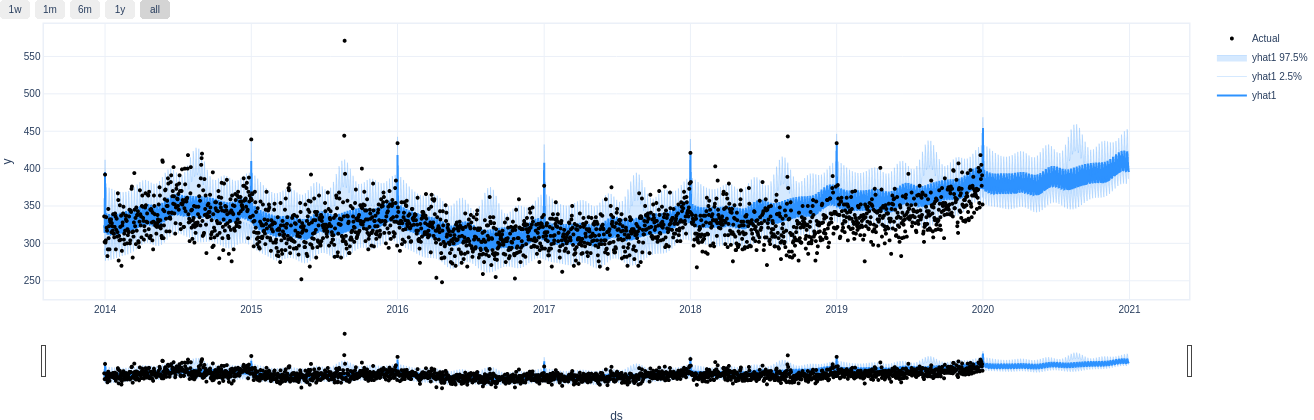

In [14]:
# Create a new dataframe reaching 365 into the future for our forecast
df_future = m.make_future_dataframe(y_train, events_df=nyd, 
                                    n_historic_predictions=True, periods=365)

# Predict the future
forecast = m.predict(df_future)

# Visualize the forecast
m.plot(forecast)

In [15]:
test_metrics = m.test(df_test)
test_metrics

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.03072650544345379
         MAE_val            21.920726776123047
        RMSE_val             26.41217803955078
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


MAE_val   RMSE_val  Loss_test  RegLoss_test
0  21.920727  26.412178   0.030727           0.0

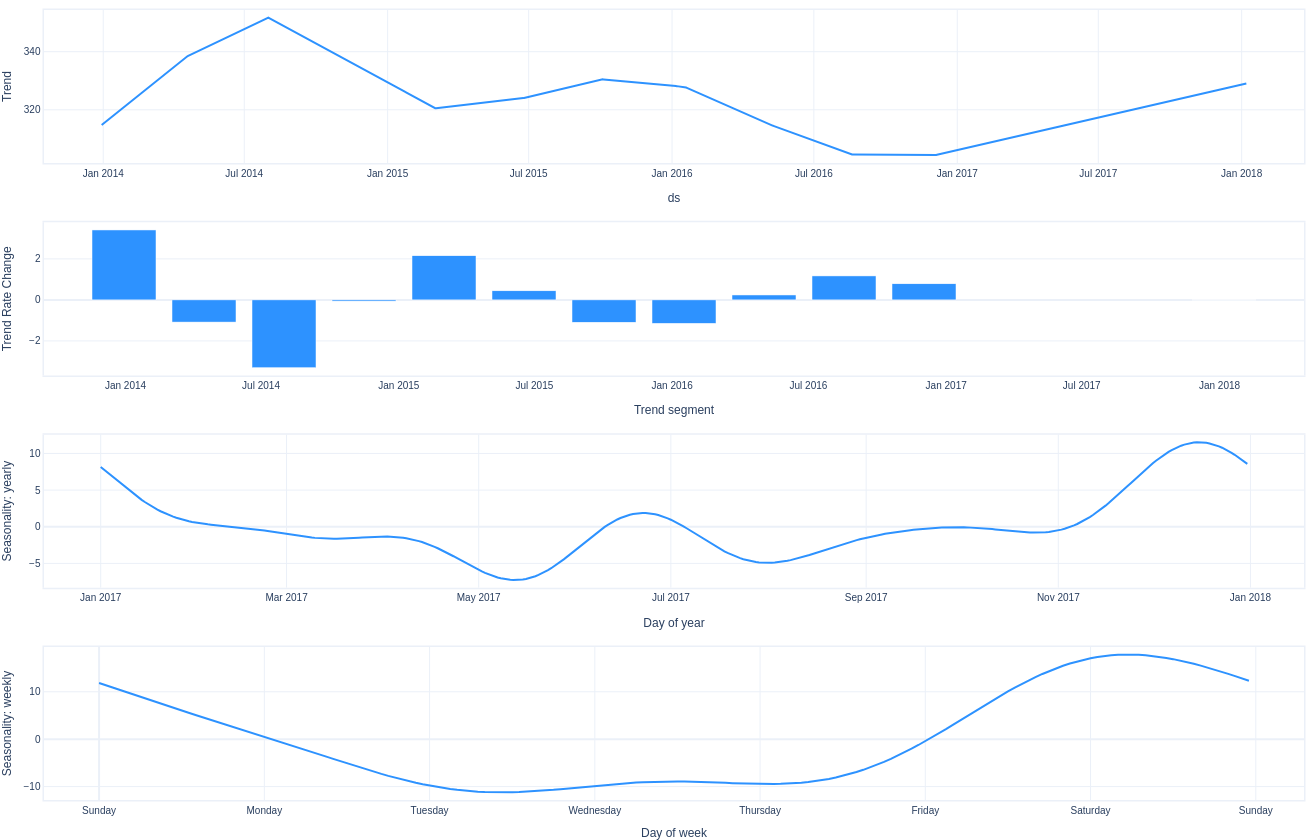

In [16]:
m.plot_parameters()

# Global Local Modelling

Our data is stored in tidy format and this turns out to be the correct format for `NeuralProphet` global models.  We just need to rename the columns.

In [17]:
df_global = pd.read_csv(url)
df_global.columns = ['ds', 'y', 'ID']
df_global.head()

ds     y               ID
0  2013-12-30   220         Cornwall
1  2013-12-30   129  Gloucestershire
2  2013-12-30   255        Wiltshire
3  2013-12-30  2042            Trust
4  2013-12-30   336           Dorset

### code to create the NeuralProphet global local model

It is simple to create the single model for all time series. We need to remember to set two additional parameters `trend_global_local` and `season_global_local` to tell the `NeuralProphet` to model the regional trend and seasonality at individual (or local) time series level.  I will also set the number of epochs to a maximum 50 to reduce training time.

In [29]:
m2 = NeuralProphet(
    trend_global_local="local",
    season_global_local="local",
    epochs=50,
    daily_seasonality=False,
    quantiles = [0.025, 0.975]
)
m2.set_plotting_backend("plotly")

nyd = new_years_day_events()
m2.add_events("new years day")
df_global = m2.create_df_with_events(df_global, nyd)

In [30]:
df_global.head()

ds    y     ID  new years day
0 2013-12-30  415  BNSSG            0.0
1 2013-12-31  420  BNSSG            0.0
2 2014-01-01  549  BNSSG            1.0
3 2014-01-02  450  BNSSG            0.0
4 2014-01-03  419  BNSSG            0.0

In [31]:
# temporal train test split
# with our new model we also need to set the local_split to true 
df_train, df_test = m2.split_df(df_global, valid_p=0.33, local_split=True)
print(df_train.shape, df_test.shape)

(11994, 4) (5898, 4)


In [32]:
metrics = m2.fit(df_train, freq="D")

Finding best initial lr:   0%|          | 0/252 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [33]:
future = m2.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m2.predict(future)

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

### We can now predict any of the regions with a single model!

For example:

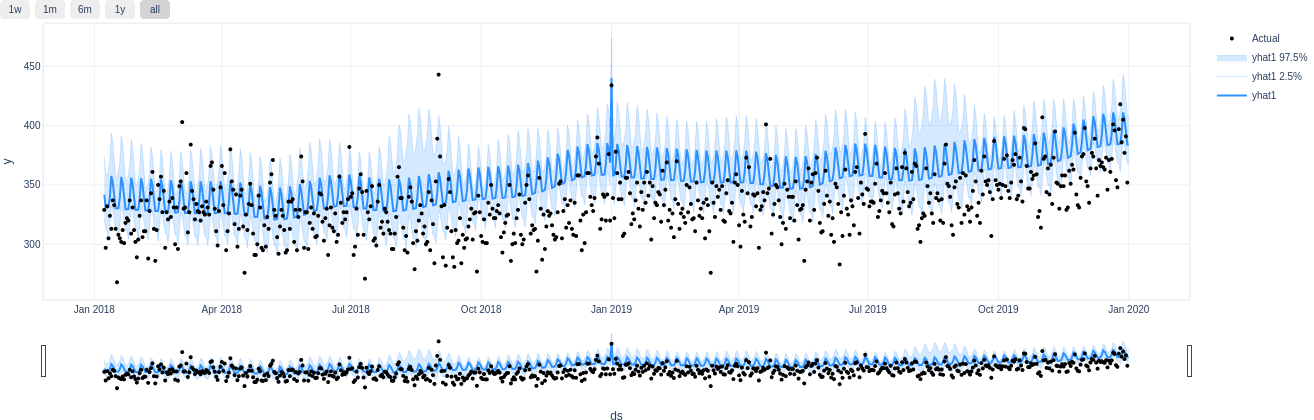

In [34]:
m2.plot(forecast[forecast["ID"] == "Dorset"])

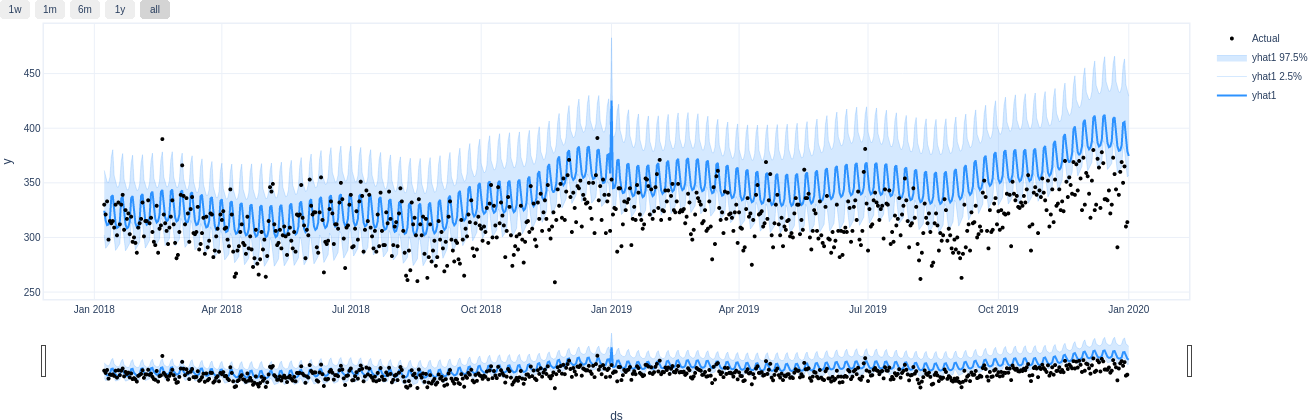

In [35]:
m2.plot(forecast[forecast["ID"] == "Wiltshire"])

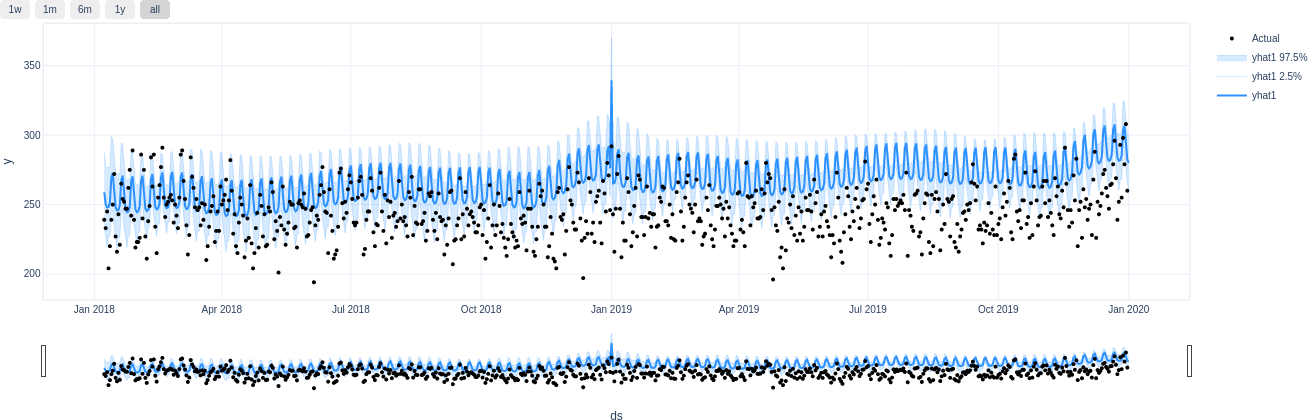

In [36]:
m2.plot(forecast[forecast["ID"] == "Cornwall"])

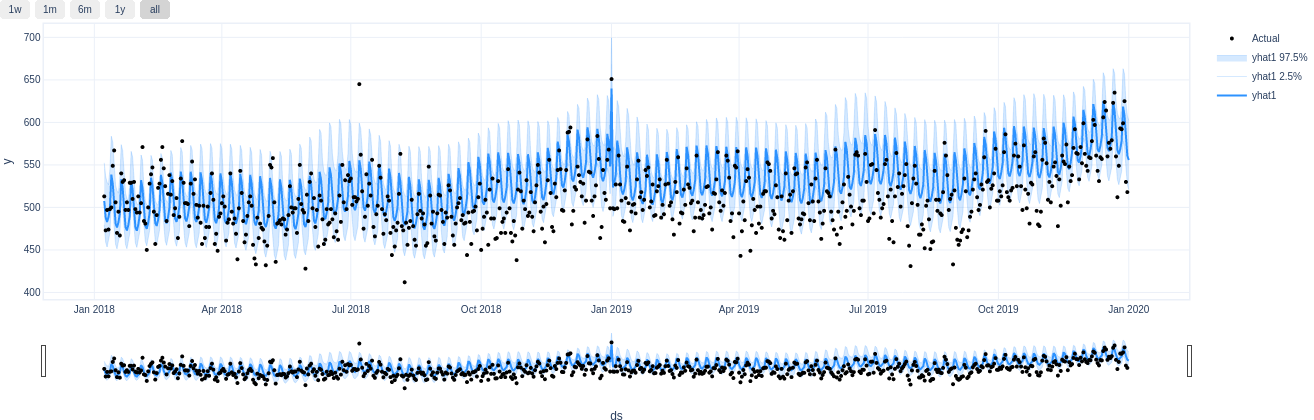

In [37]:
m2.plot(forecast[forecast["ID"] == "BNSSG"])

One issue to note is that the metrics outputted for the model are reported on a normalised scale.  It is therefore better to assess your forecast accuracy with your own code or a tool like `forecast-tools`

In [38]:
test_metrics_global = m2.test(df_test)
test_metrics_global

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06246213614940643
         MAE_val            0.23970238864421844
        RMSE_val            0.2914621829986572
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


MAE_val  RMSE_val  Loss_test  RegLoss_test
0  0.239702  0.291462   0.062462           0.0